In [14]:
import os
import librosa 
import torch
import matplotlib
import matplotlib.pyplot as plt
import random
import IPython.display as ipd

matplotlib.use('Agg')

%matplotlib inline

from matplotlib.colors import Normalize
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import ArgumentParser
from omegaconf import OmegaConf
from unicodedata import normalize
import re

#from utils.utils import get_commit_hash
from lightning_model import Wavegrad2
from text import Language
from text.symbols import eng_symbols
from g2p_en import G2p
from dataloader import TextAudioDataset


if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('-c', '--config', type=str, required=True,
                        help="path of configuration yaml file")
    parser.add_argument('-g', '--gpus', type=str, default=None,
        help="Number of gpus to use (e.g. '0,1,2,3'). Will use all if not given.")
    parser.add_argument('-n', '--name', type=str, required=True,
                        help="Name of the run.")
    parser.add_argument('-p', '--checkpoint_path', type=str, default=None,
                        help="path of checkpoint for resuming")

    lu=['-c','hparameter.yaml','-n','trash','-p']
    
#     lu.append('/workspace/checkpoint/wavegrad2_07_02_08_epoch=649.ckpt')
    lu.append('/workspace/checkpoint/last.ckpt')
    speaker = 'LJSpeech'
    
    args = parser.parse_args(lu)

    net=Wavegrad2.load_from_checkpoint(args.checkpoint_path).cuda().eval()
    net.freeze()
    
    hparams =net.hparams

In [15]:

    text=input('문자열을 입력하세요: ')

    #text="On Friday night in Bridgeport expect a temperature of minus four degrees Fahrenheit."
    
    g2p = G2p()
    phones = []
    words = re.split(r"([,;.\-\?\!\s+])", text)
    for w in words:
        phones += list(filter(lambda p: p != " ", g2p(w)))
    phones = "{" + "}{".join(phones) + "}"
    phones = re.sub(r"\{[^\w\s]?\}", "{sp}", phones)
    print('g2p: ',phones)
    
    trainset = TextAudioDataset(hparams, hparams.data.train_dir, hparams.data.train_meta, train=False)

    text=trainset.get_text(phones)
    text=text.unsqueeze(0)
    
    speaker_dict = {spk: idx for idx, spk in enumerate(hparams.data.speakers)}
    spk_id=[speaker_dict[speaker]]
    spk_id = torch.LongTensor(spk_id)
    
    text=text.cuda()
    spk_id=spk_id.cuda()
    
    wav_recon, align = net.inference(text,spk_id, pace=1.0)


문자열을 입력하세요: On Friday night in Bridgeport expect a temperature of minus four degrees Fahrenheit.
g2p:  {AA1}{N}{F}{R}{AY1}{D}{IY0}{N}{AY1}{T}{IH0}{N}{B}{R}{IH1}{JH}{P}{AO2}{R}{T}{IH0}{K}{S}{P}{EH1}{K}{T}{AH0}{T}{EH1}{M}{P}{R}{AH0}{CH}{ER0}{AH1}{V}{M}{AY1}{N}{AH0}{S}{F}{AO1}{R}{D}{IH0}{G}{R}{IY1}{Z}{F}{EH1}{R}{AH0}{N}{HH}{AY2}{T}{sp}


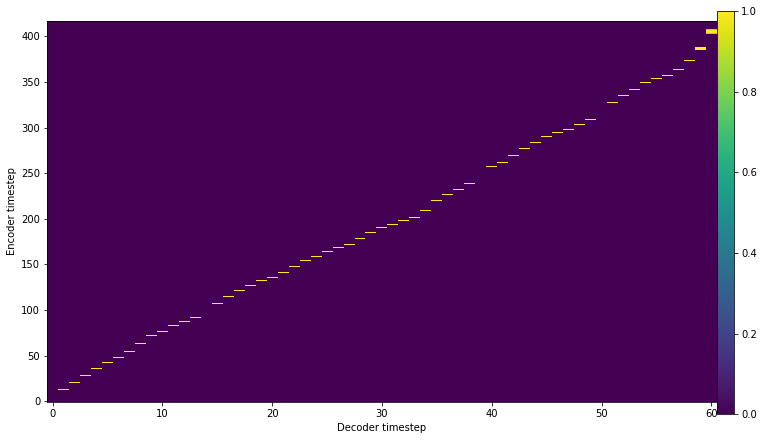

In [16]:
    %matplotlib inline
    align = align.cpu()
    align = align.squeeze(0)
    align = align.T
    fig = plt.figure(figsize=(12, 7))
    plt.imshow(align, aspect='auto', origin='lower', interpolation='none',
        norm=Normalize(vmin=0.0, vmax=1.0))
   
    plt.xlabel('Decoder timestep')
    plt.ylabel('Encoder timestep')
    
    cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    plt.colorbar(cax=cax)

In [17]:
wav_recon = wav_recon.cpu().squeeze(0)
ipd.Audio(wav_recon, rate=hparams.audio.sampling_rate)

In [5]:
    mel_img=mel.squeeze(0)
    mel_img=mel_img.cpu().detach().numpy()
    
    
    fig = plt.figure(figsize=(135,27))
    #cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    #plt.colorbar(format='%+2.0f dB')
    plt.savefig('mel.png')
    plt.imshow(mel_img, aspect = 'auto', origin='lower', interpolation='none')

NameError: name 'mel' is not defined